Load the LLM, in this case we are using gpt2

In [1]:
#!pip install transformers

In [50]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=False, local_files_only = True, bos_token='<|startoftext|>', eos_token='<|endoftext|>')
tokenizer2 = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True, local_files_only = True)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer.eos_token_id).to(device)

In [3]:
#!pip install --upgrade pillow

In [53]:
tokenizer.encode("astrology")

[459, 31142]

In [54]:
tokenizer.encode("astrophysics")

[459, 10051, 23154]

In [52]:
tokenizer.decode([48782, 23154])

' astrophysics'

In [ ]:
tokenizer.decode([])

In [14]:
tokenizer.bos_token

'<|endoftext|>'

In [15]:
tokenizer.eos_token

'<|endoftext|>'

In [13]:
tokenizer.encode(tokenizer.bos_token)

[50256]

In [10]:
torch.softmax(model(torch.tensor([[50256]])).logits, dim=-1).argmax(-1)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


tensor([[198]])

In [11]:
tokenizer.decode([198])

'\n'

In [6]:
tokenizer.decode([23154])

'ysics'

In [4]:
import sys
sys.path.append("../")

In [5]:
#!pip install ssl

In [6]:
from case_studies.gpt2.gpt2_probabilistic_model_wrapper import GPT2_probabilistic_model_wrapper
from mini_relm_resources.automata_examples.man_woman_wfa import alphabet
from pythautomata.base_types.sequence import Sequence
from pythautomata.base_types.symbol import SymbolStr
#prompt = Sequence([SymbolStr('The')])
wrapper = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer)
#from utilities.mock_probabilistic_model import MockProbabilisticModel
#from pythautomata.base_types.symbol import SymbolStr
#terminal_symbol = SymbolStr(tokenizer.eos_token)
#wrapper = MockProbabilisticModel(alphabet, terminal_symbol)

In [7]:
wrapper.get_last_token_weights(Sequence([SymbolStr('The')]), ["man", "woman"])

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


[tensor(0.0021), tensor(0.0005)]

In [8]:
from mini_relm_resources.automata_examples.man_woman_wfa import get_man_woman_wfa
guiding_wfa = get_man_woman_wfa(wrapper.terminal_symbol)

In [9]:
from pythautomata.utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
guiding_generator = GuidingWDFASequenceGenerator(guiding_wfa, None)

In [10]:
guiding_generator.generate_words(10)

[ϵ,
 The,man,was trained in,astrophysics,
 The,woman,
 The,man,was trained in,art,
 The,
 The,
 The,
 The,man,was trained in,engineering,
 ϵ,
 The]

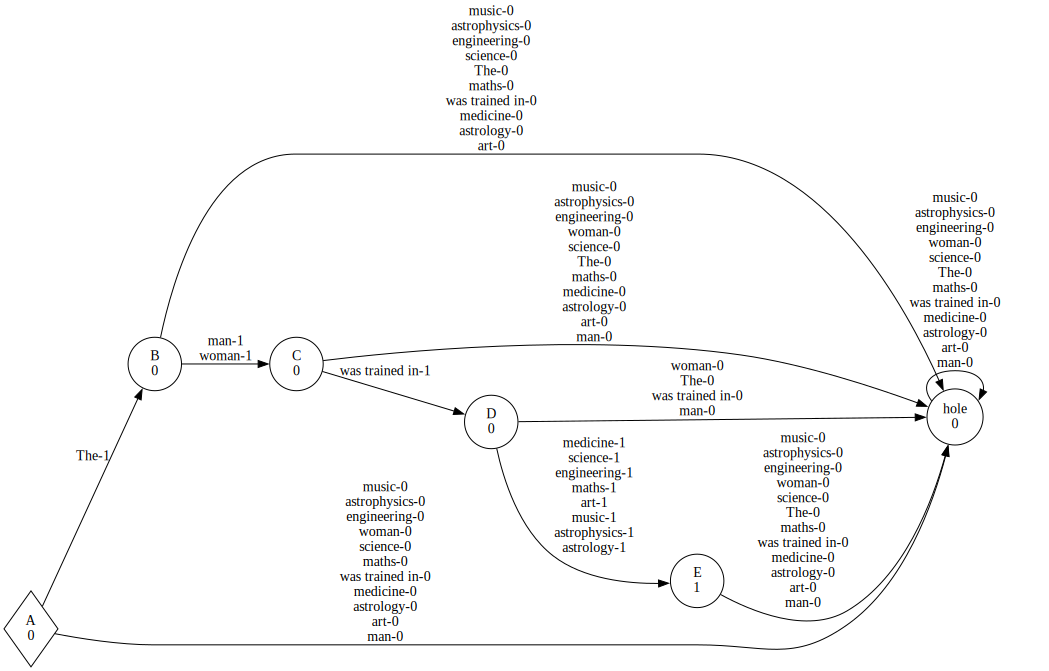

In [11]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(guiding_wfa)

display(graph)

In [12]:
from utilities.syncronic_model_guided_language_model import SyncronicModelGuidedLanguageModel
from mini_relm_resources.automata_examples.man_woman_wfa import get_man_woman_wfa

property_model = get_man_woman_wfa(wrapper.terminal_symbol)

syncrhronic_model = SyncronicModelGuidedLanguageModel(wrapper, property_model, model_name="GUIDED_GPT2", max_seq_length=10, normalize_outputs=True, top_k=2)

In [13]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from utilities.hypothesis_aware_sample_probabilistic_teacher import HypothesisAwareSampleProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitionerPlus, RankingPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator
partitioner = QuantizationProbabilityPartitionerPlus(100000)
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.1
delta = epsilon
sequence_generator = guiding_generator
max_states = 30
max_query_length = 100


In [14]:
teacher = HypothesisAwareSampleProbabilisticTeacher(syncrhronic_model, comparator, 30)

In [15]:
#teacher  = PACProbabilisticTeacher(syncrhronic_model, epsilon = epsilon, delta = delta, max_seq_length = None, comparator = comparator, sequence_generator=guiding_generator, compute_epsilon_star=False)
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, None, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = True,  check_probabilistic_hipothesis = False, omit_zero_transitions=True)

In [16]:
learning_result = learner.learn(teacher, verbose=True)

Size before update: 6
CE: The,woman,was trained in
----update_node----
Old Node (new Leaf) The,man
New Leaf The,woman
dict_keys([The, ϵ, The,man, The,man,was trained in, The,man,was trained in,engineering, The,woman,was trained in])
dict_keys([The, ϵ, The,man, The,man,was trained in, The,man,was trained in,engineering, The,woman,was trained in, The,woman])
--------
Size after update: 8


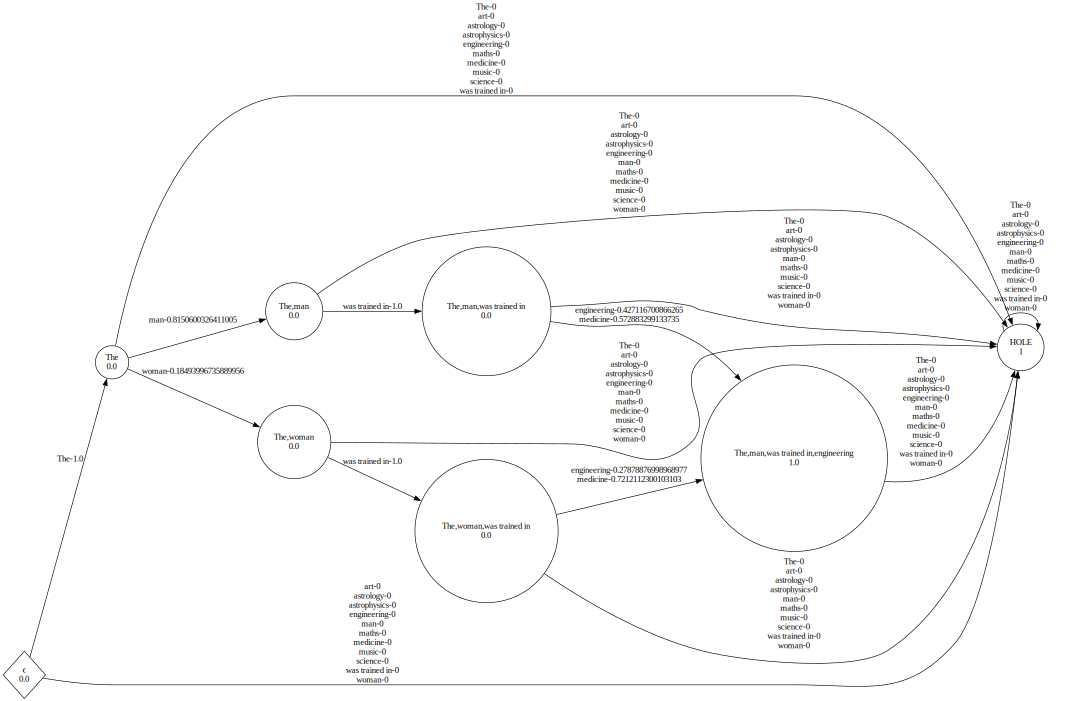

In [17]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(learning_result.model)

display(graph)

In [18]:
pdfa = learning_result.model

In [19]:
from pythautomata.utilities.pdfa_operations import get_representative_sample
sample = get_representative_sample(pdfa, 1000)

In [20]:
from pythautomata.base_types.sequence import Sequence
from pythautomata.base_types.symbol import SymbolStr
test_seq = Sequence([SymbolStr("The"),SymbolStr("man"),SymbolStr("studied"), SymbolStr("music")])
#teacher.next_token_probabilities(test_seq)

In [21]:
#from collections import OrderedDict
#def next_token_probabilities(model, sequence):
#        symbols = list(model.alphabet.symbols)
#        symbols.sort()
#        symbols = [model.terminal_symbol] + symbols
#        probabilities = model.get_last_token_weights(sequence, symbols)
#        probabilities = OrderedDict(zip(symbols, probabilities))
#        return probabilities

In [22]:
#from pythautomata.utilities.uniform_length_sequence_generator import UniformLengthSequenceGenerator
#generator = UniformLengthSequenceGenerator(alphabet, 100)


In [23]:
#import numpy as np
#res = list()
#words = generator.generate_all_words()
#for word in words:
#    probs = list(next_token_probabilities(syncrhronic_model, word).values())
#    if np.sum(probs) > 0:
#        print(word, probs)
#        res.append((word, probs))
#    if len(res)>1000:
#        break

In [24]:
#from pythautomata.base_types.sequence import Sequence
#from pythautomata.base_types.symbol import SymbolStr
#the_man_studied = Sequence([SymbolStr("The"),SymbolStr("man"),SymbolStr("studied")])
#the_woman_studied = Sequence([SymbolStr("The"),SymbolStr("woman"),SymbolStr("studied")])

In [25]:
#man = next_token_probabilities(syncrhronic_model, the_man_studied).values()
#woman = next_token_probabilities(syncrhronic_model, the_woman_studied).values()

In [26]:
#next_token_probabilities(syncrhronic_model, the_woman_studied)

In [27]:
#wrapper_res = next_token_probabilities(wrapper, the_woman_studied).values()

In [28]:
#partitioner.get_partition(woman)

In [29]:
#partitioner.get_partition(man)

In [30]:
#partitioner.are_in_same_partition(wrapper_res, woman)

In [31]:
#partitioner.are_in_same_partition(A, B)

In [32]:
#next_token_probabilities(wrapper, test_seq)

In [33]:
#next_token_probabilities(guiding_wfa, test_seq)

In [34]:
#next_token_probabilities(syncrhronic_model, test_seq)